In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

数据探索

In [2]:
data = pd.read_csv("../data/training.txt", sep=" ", header=None, names=['user_id', 'item_id', 'click'])
data.head()

,user_id,item_id,click
0,298,474,1
1,253,465,1
2,286,1014,1
3,200,222,1
4,122,387,1


In [3]:
data.duplicated(subset=['user_id','item_id']).sum() 
# 发现不存在重复的行

0

In [4]:
print(data.shape)
print(data.nunique())

(44234, 3)
user_id     942
item_id    1412
click         1
dtype: int64


In [5]:
target_user = pd.read_csv("../data/test.txt", sep=" ", header=None, names=['user_id'])
target_user.drop_duplicates(subset=["user_id"],keep="first", inplace=True)
target_user.shape
# 需要进行top-n推荐的用户只有926个

(926, 1)

In [6]:
data[~data['user_id'].isin(target_user['user_id'].tolist())].user_id.unique()

array([108, 289,  86, 155, 273, 400, 490, 443, 544, 631, 656, 646, 792,
       857, 822, 578], dtype=int64)

training中存在942个不同的用户，test中只包含926个用户，有16个用户不在test中。

In [7]:
target_user.describe()

,user_id
count,926.000000
mean,471.534557
std,272.910488
min,1.000000
25%,235.250000
50%,470.500000
75%,708.750000
max,943.000000


In [8]:
data.describe()

,user_id,item_id,click
count,44234.000000,44234.000000,44234.0
mean,459.633269,377.046073,1.0
std,267.952940,300.498038,0.0
min,1.000000,1.000000,1.0
25%,253.000000,160.000000,1.0
50%,445.500000,286.000000,1.0
75%,682.000000,527.000000,1.0
max,943.000000,1674.000000,1.0


In [9]:
# 可以发现user_id编号最小是1，最大是943，item_id编号最小是1，最大是1674。因此需要将编号重新映射一次
# 创建用户ID和物品ID的映射
user_id_map = {id: i for i, id in enumerate(data['user_id'].unique())}
item_id_map = {id: i for i, id in enumerate(data['item_id'].unique())}

# 应用映射
data['user_id'] = data['user_id'].map(user_id_map)
data['item_id'] = data['item_id'].map(item_id_map)
target_user['user_id'] = target_user['user_id'].map(user_id_map)

In [10]:
data.describe()

,user_id,item_id,click
count,44234.000000,44234.000000,44234.0
mean,431.296130,331.144391,1.0
std,283.761902,275.367923,0.0
min,0.000000,0.000000,1.0
25%,154.000000,116.000000,1.0
50%,437.000000,258.000000,1.0
75%,669.000000,487.000000,1.0
max,941.000000,1411.000000,1.0


In [11]:
target_user.describe()

,user_id
count,926.000000
mean,469.155508
std,272.512009
min,0.000000
25%,232.250000
50%,468.500000
75%,704.750000
max,941.000000


In [12]:
#统计每个物品对应的用户数
item_id_usercnt = data.groupby("item_id").count().user_id
item_id_usercnt[:10]

item_id
0    125
1     42
2     28
3    172
4     28
5      9
6     27
7     30
8    132
9    258
Name: user_id, dtype: int64

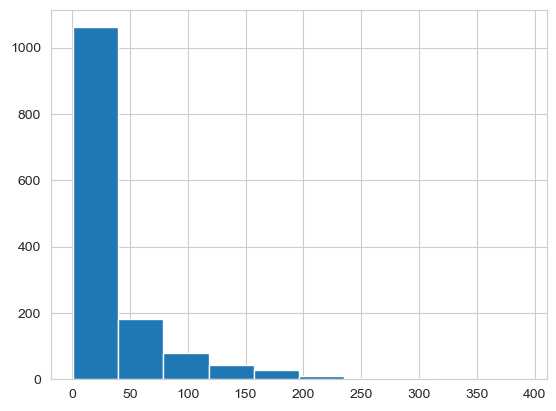

In [13]:
plt.hist(item_id_usercnt.values)
plt.show()

In [14]:
item_id_usercnt.quantile(q=np.arange(0,1.1,0.1))

0.0      1.0
0.1      1.0
0.2      2.0
0.3      4.0
0.4      7.0
0.5     11.0
0.6     20.0
0.7     31.0
0.8     50.0
0.9     88.0
1.0    391.0
Name: user_id, dtype: float64

In [15]:
user_id_itemcnt = data.groupby('user_id').count().item_id
user_id_itemcnt[:10]

user_id
0     70
1     59
2    148
3    124
4     38
5    155
6     97
7     38
8    113
9    198
Name: item_id, dtype: int64

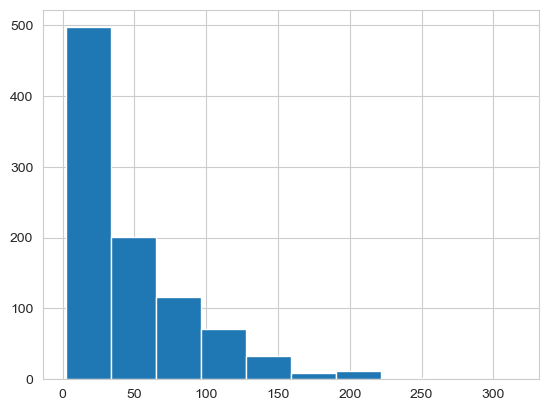

In [16]:
plt.hist(user_id_itemcnt.values)
plt.show()

In [17]:
user_id_itemcnt.quantile(q=np.arange(0,1.1,0.1))

0.0      2.0
0.1      9.0
0.2     13.2
0.3     18.0
0.4     23.0
0.5     31.0
0.6     39.0
0.7     56.0
0.8     77.0
0.9    108.9
1.0    316.0
Name: item_id, dtype: float64

In [18]:
# 拆分训练集和测试集
def split_train_test(data, test_size=0.2):
    train_data = []
    test_data = []
    for user, group in data.groupby('user_id'):
        n_test_items = max(1, int(len(group) * test_size))
        test_items = group.sample(n=n_test_items)
        train_items = group.drop(test_items.index)
        train_data.append(train_items)
        test_data.append(test_items)
    return pd.concat(train_data), pd.concat(test_data)

In [19]:
train_data,test_data = split_train_test(data)

print(f"训练集大小: {len(train_data)} ({len(train_data)/len(data):.2%})")
print(f"测试集大小: {len(test_data)} ({len(test_data)/len(data):.2%})")

print(f"训练集中的用户数: {train_data['user_id'].nunique()}")
print(f"测试集中的用户数: {test_data['user_id'].nunique()}")

训练集大小: 35754 (80.83%)
测试集大小: 8480 (19.17%)
训练集中的用户数: 942
测试集中的用户数: 942


In [20]:
train_data.nunique()

user_id     942
item_id    1375
click         1
dtype: int64

In [21]:
n_users = data.user_id.nunique()
n_items = data.item_id.nunique()

In [22]:
# 训练集 用户-物品 矩阵
user_item_matrix = np.zeros((n_users,n_items))
for line in train_data.itertuples():
    user_item_matrix[line[1]-1,line[2]-1] = line[3]

In [23]:
# 构建相似度
from sklearn.metrics.pairwise import pairwise_distances,cosine_similarity
from collections import defaultdict

user_similarity_m = cosine_similarity(user_item_matrix)

In [24]:
user_similarity_m_triu = np.triu(user_similarity_m,k=1) # 取得上三角数据
user_sim_nonzero = np.round(user_similarity_m_triu[user_similarity_m_triu.nonzero()],3)
np.percentile(user_sim_nonzero,np.arange(0,101,10))

array([0.01 , 0.039, 0.053, 0.067, 0.082, 0.098, 0.116, 0.138, 0.165,
       0.204, 0.707])

In [25]:
def get_top_n_recommendations(user_item_matrix, user_similarity, n=10, top_k_users=10):
    recommendations = defaultdict(list)
    user_ids = user_item_matrix.index
    
    for i, user_id in enumerate(user_ids):
        user_vector = user_item_matrix.iloc[i]
        similar_users = user_similarity[i].argsort()[::-1][1:top_k_users+1]
        
        for item_id in user_item_matrix.columns:
            if user_vector[item_id] == 0:
                similar_users_ratings = user_item_matrix.iloc[similar_users, item_id]
                similar_users_similarities = user_similarity[i, similar_users]
                score = np.sum(similar_users_ratings * similar_users_similarities) / np.sum(similar_users_similarities)
                
                if score > 0:
                    recommendations[user_id].append((item_id, score))
        
        recommendations[user_id] = sorted(recommendations[user_id], key=lambda x: x[1], reverse=True)[:n]
    
    return recommendations

In [31]:
def evaluate(recommendations, test_data, k=10):
    precision = defaultdict(float)
    recall = defaultdict(float)
    
    for user, user_recs in recommendations.items():
        user_test = set(test_data[test_data['user_id'] == user]['item_id'])
        recs = set([item for item, _ in user_recs[:k]])
        
        if len(recs) > 0:
            precision[user] = len(recs & user_test) / len(recs)
        if len(user_test) > 0:
            recall[user] = len(recs & user_test) / len(user_test)
    
    avg_precision = np.mean(list(precision.values()))
    avg_recall = np.mean(list(recall.values()))
    
    return avg_precision, avg_recall

In [30]:
user_item_matrix2 = pd.DataFrame(user_item_matrix)

In [32]:
recommendations = get_top_n_recommendations(user_item_matrix2, user_similarity_m, n=10, top_k_users=10)
precision, recall = evaluate(recommendations, test_data)
print(f"Precision@10: {precision:.4f}")
print(f"Recall@10: {recall:.4f}")

Precision@10: 0.0149
Recall@10: 0.0172


In [33]:
for user, group in data.groupby('user_id'):
    print(user)
    print(group)
    break

0
       user_id  item_id  click
0            0        0      1
62           0       59      1
813          0      438      1
1128         0      296      1
1210         0      534      1
...        ...      ...    ...
32786        0      309      1
33082        0      181      1
33109        0      185      1
42531        0      437      1
43741        0      409      1

[70 rows x 3 columns]


In [36]:
user_item_matrix2.iloc[[1,2,3,5,7,1], 2].shape

(6,)

In [42]:
precision, recall = evaluate(recommendations, test_data,k=4)
print(f"Precision@10: {precision:.4f}")
print(f"Recall@10: {recall:.4f}")

Precision@10: 0.0146
Recall@10: 0.0072


In [55]:
user_id_itemcnt[data[~data['user_id'].isin(target_user['user_id'].tolist())].user_id.unique()]

user_id
168    16
266     9
279    11
287     3
340    13
404    13
481    18
498    12
608     7
615     9
690     4
750     5
789    16
852    10
864    10
882     5
Name: item_id, dtype: int64